In [1]:
import numpy as np
import matplotlib.pyplot as plt
import myokit
import pandas as pd
from scipy.signal import find_peaks

In [2]:
mmt_ap_original = myokit.load_model('dutta-2017.mmt')
mmt_ap = myokit.load_model('dutta-2017-gray-2020-ina.mmt')
mmt_ina = myokit.load_model('gray-2020-ina.mmt')

CURRENTS = {
    'ina': 'ina.INa',
}
LOG_CURRENTS = {c: [CURRENTS[c], 'membrane.V'] for c in CURRENTS}
LOG = ['membrane.V'] + list(CURRENTS.values())  # For dutta-2017.mmt

SCALINGS = {  # Scaling factors for the currents
    'ina': 1,
}

DT = 0.1 # ms
TIME = np.arange(0, 2000, DT)  # ms

Text(0, 0.5, 'Current (A/F)')

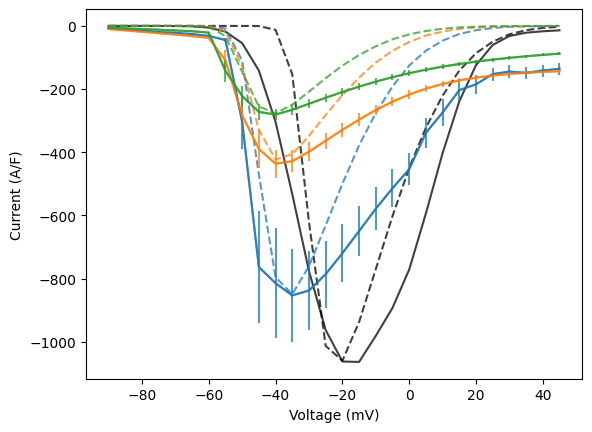

In [3]:
v_steps = np.arange(-90, 50, 5)

def setup_simulation(sample_freq=0.00004):
    mod = myokit.load_model('gray-2020-ina.mmt')
    if mod.time_unit().multiplier() == .001:
        scale = 1000
    else:
        scale = 1
    # Run for 20 s before running the VC protocol
    holding_proto = myokit.Protocol()
    holding_proto.add_step(-.080*scale, 30*scale)
    holding_t_max = holding_proto.characteristic_time()
    holding_sim = myokit.Simulation(mod, holding_proto)
    # Run the VC protocol
    proto = myokit.Protocol()
    for v in v_steps:
        proto.add_step(-100, 2000)
        proto.add_step(v, 20)
    t_max = proto.characteristic_time()
    times = np.arange(0, t_max, sample_freq*scale)
    sim = myokit.Simulation(mod, proto)
    return holding_sim, sim, holding_t_max, t_max, times

def simulate_model(param, holding_sim, sim, holding_t_max, t_max, times):
    gna, p1 = param
    holding_sim.reset()
    # Em = Em_original + p1; Eh = Eh_original + p3
    # Want both Em and Eh to change TOGETHER such that the time constants
    # are not affected while changing the IV curve.
    holding_sim.set_constant('ina.p1', p1)
    holding_sim.set_constant('ina.p3', p1)
    holding_sim.set_constant('ina.g_Na', gna)
    holding_sim.run(holding_t_max)
    sim.reset()
    sim.set_state(holding_sim.state())
    sim.set_constant('ina.p1', p1)
    sim.set_constant('ina.p3', p1)
    sim.set_constant('ina.g_Na', gna)
    dat = sim.run(t_max, log_times=times)
    return dat


def get_iv_data(dat):
    iv_dat = {}
    i_out = [v for v in dat['ina.i_Na']]
    v = np.array(dat['engine.pace'])
    step_idxs = np.where(np.diff(v) > .005)[0]
    v_steps = v[step_idxs + 10]
    iv_dat['Voltage'] = v_steps
    #print(v_steps)
    currs = []
    for idx in step_idxs:
        #temp_currs = i_out[(idx+3):(idx+103)]
        temp_currs = i_out[(idx):(idx+103)]
        #plt.plot(temp_currs)
        x = find_peaks(-np.array(temp_currs)) #distance=5, width=4)
        if len(x[0]) < 1:
            currs.append(np.min(temp_currs))
        else:
            currs.append(temp_currs[x[0][0]])
        #plt.axhline(currs[-1])
    iv_dat['Current'] = currs
    return iv_dat


def run(parameters):
    holding_sim, sim, holding_t_max, t_max, times = setup_simulation()
    dat = simulate_model(parameters, holding_sim, sim,
                         holding_t_max, t_max, times)
    iv_dat = get_iv_data(dat)
    return iv_dat


PARAMS = []

data_b = np.loadtxt('./data/baseline.csv')
param_b = np.loadtxt(f'./data/gray2020-optimal_params-baseline.csv')
param_b[0] *= 0.85

plt.plot(v_steps, data_b, c='black', alpha=0.75, label='Baseline')
plt.plot(v_steps, run(param_b)['Current'], c='black', alpha=0.75, linestyle='--')

PARAMS.append(param_b)
CASES = [1, 2, 3]

for i, CASE in enumerate(CASES):
    all_iv = pd.read_csv(f'./data/case-{CASE}/all_iv.csv').T
    np.random.seed(0)
    choice = np.random.choice(len(all_iv.T), 25, replace=False)
    d = []
    for iv in all_iv.values[:, choice].T:
        d.append(iv)
        #plt.plot(v_steps, iv, c='gray', alpha=0.15)
    data = np.mean(d, axis=0)
    param = np.loadtxt(f'./data/gray2020-optimal_params-case-{CASE}.csv')
    param[0] *= 0.8
    PARAMS.append(param)

    plt.plot(v_steps, data, c=f'C{i}', alpha=0.75, label=f'Case {CASE}')
    plt.errorbar(v_steps, data, yerr=np.std(d, axis=0) / np.sqrt(len(d)), c=f'C{i}', alpha=0.75)
    plt.plot(v_steps, run(param)['Current'], c=f'C{i}', alpha=0.75, linestyle='--')

plt.xlabel('Voltage (mV)')
plt.ylabel('Current (A/F)')

In [4]:
# Utility functions

def setup(m, label='pace'):
    # Set up the model for pacing
    stim_amp_var = 'stimulus.amplitude'  # For dutta-2017.mmt
    m.set_max_step_size(1e-1)  # ms
    m.set_tolerance(1e-8, 1e-10)
    m.set_constant(stim_amp_var, -80)
    p = myokit.pacing.blocktrain(period=500,
                                 duration=1,
                                 #duration=0.5,
                                 offset=50,
                                 level=1)
                                 #level=2)
                                 #level=0.75)
    m.set_protocol(p, label=label)
    m.pre(10000)
    return m


def detach_currents(m, currents):
    # Detach currents from the model
    m = m.clone()
    paces = []
    for c in currents:
        x = m.get(currents[c])
        if x.is_state():
            x.demote()
        x.set_rhs(0)
        p = 'pace_' + c
        x.set_binding(p)
        paces.append(p)
    return m, paces


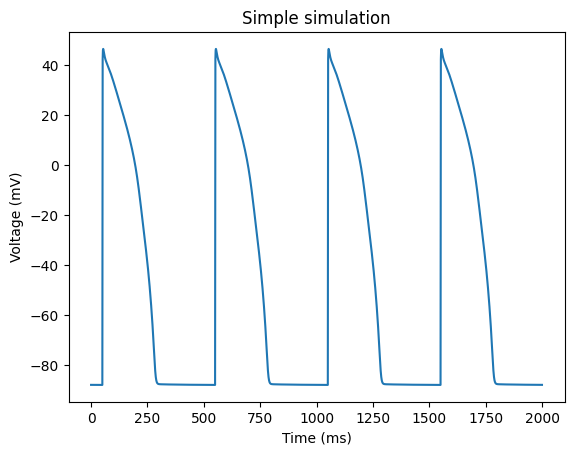

In [5]:
ideal = myokit.Simulation(mmt_ap_original)
ideal = setup(ideal)

d0 = ideal.run(2000, log_times=TIME, log=LOG)
ideal.reset()

plt.plot(TIME, d0['membrane.V'], c='C0')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Simple simulation')
plt.show()

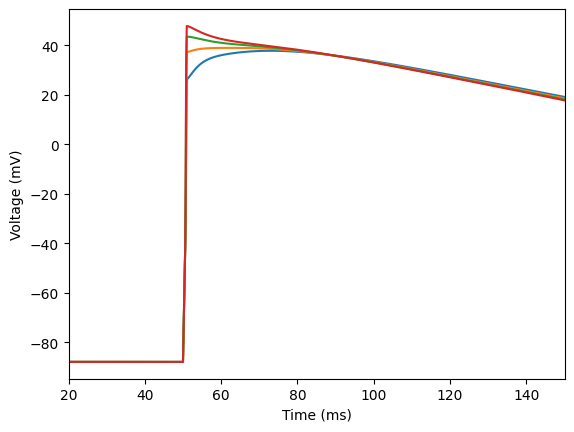

In [6]:
ideal = myokit.Simulation(mmt_ap)
ideal = setup(ideal)

for i in [5, 10, 15, 20]:
    ideal.set_constant('ina.gNa', i)
    d0 = ideal.run(TIME[-1]+1, log_times=TIME, log=LOG)
    ideal.reset()
    plt.plot(TIME, d0['membrane.V'])#, c='C0')

plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
#plt.title('Simple simulation')
plt.xlim([20, 150])
plt.show()

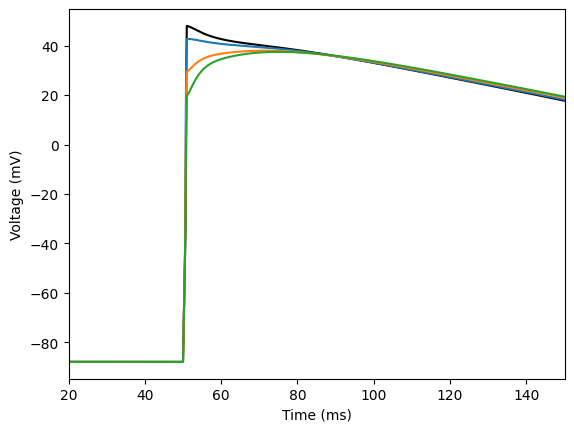

In [7]:
ideal = myokit.Simulation(mmt_ap)
ideal = setup(ideal)

colors = ['black','C0', 'C1', 'C2']
for i, p in enumerate(PARAMS):
    ideal.set_constant('ina.gNa', p[0])
    ideal.set_constant('ina.p1', p[1])
    ideal.set_constant('ina.p3', p[1])
    d0 = ideal.run(TIME[-1]+1, log_times=TIME, log=LOG)
    ideal.reset()
    plt.plot(TIME, d0['membrane.V'], c=colors[i])

plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.xlim([20, 150])
plt.show()

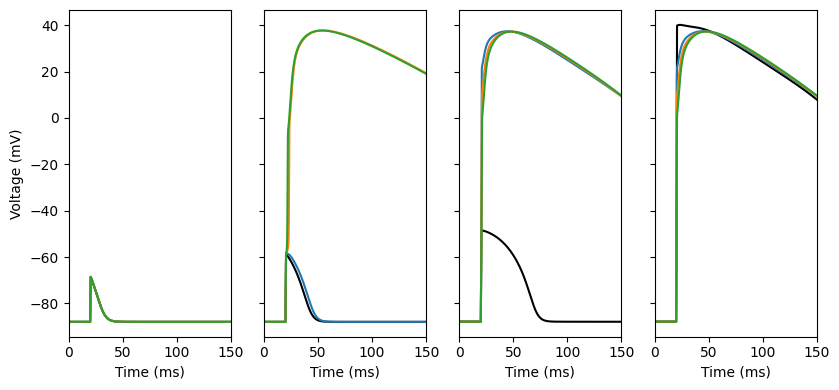

In [8]:
# Test different stim amps (take off potential)

fig, axes = plt.subplots(1, 4, figsize=(8.5, 4), sharex=True, sharey=True)

for i_v, v in enumerate([0.5, 0.75, 1, 1.5]):
    m = myokit.Simulation(mmt_ap)
    stim_amp_var = 'stimulus.amplitude'  # For dutta-2017.mmt
    m.set_max_step_size(1e-1)  # ms
    m.set_tolerance(1e-8, 1e-10)
    m.set_constant(stim_amp_var, -80)
    p = myokit.pacing.blocktrain(period=500,
                                 #duration=1,
                                 duration=0.5,
                                 offset=20,
                                 level=v)
                                 #level=2)
                                 #level=0.75)
    m.set_protocol(p, label='pace')
    m.pre(10000)

    colors = ['black','C0', 'C1', 'C2']
    for i, p in enumerate(PARAMS):
        m.set_constant('ina.gNa', p[0])
        m.set_constant('ina.p1', p[1])
        m.set_constant('ina.p3', p[1])
        d0 = m.run(TIME[-1]+1, log_times=TIME, log=LOG)
        m.reset()
        axes[i_v].plot(TIME, d0['membrane.V'], c=colors[i])

    axes[i_v].set_xlabel('Time (ms)')

axes[0].set_ylabel('Voltage (mV)')
axes[0].set_xlim([0, 150])
plt.tight_layout()
plt.show()

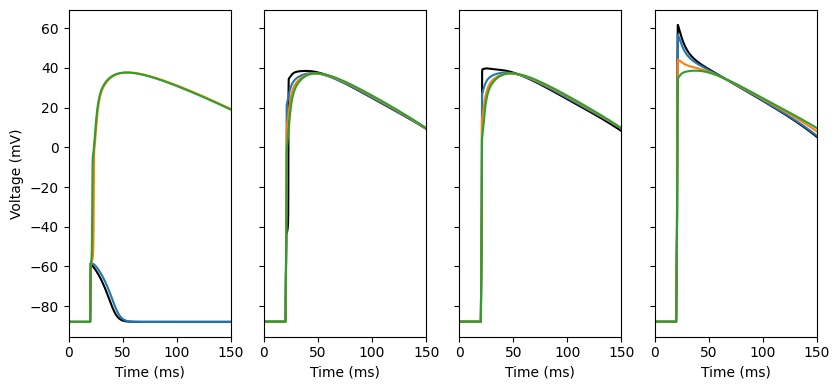

In [9]:
# Test different stim durations (take off potential)

fig, axes = plt.subplots(1, 4, figsize=(8.5, 4), sharex=True, sharey=True)

for i_v, v in enumerate([0.5, 0.75, 1, 1.5]):
    m = myokit.Simulation(mmt_ap)
    stim_amp_var = 'stimulus.amplitude'  # For dutta-2017.mmt
    m.set_max_step_size(1e-1)  # ms
    m.set_tolerance(1e-8, 1e-10)
    m.set_constant(stim_amp_var, -80)
    p = myokit.pacing.blocktrain(period=500,
                                 #duration=1,
                                 duration=v,
                                 offset=20,
                                 level=0.75)
                                 #level=2)
                                 #level=0.75)
    m.set_protocol(p, label='pace')
    m.pre(10000)

    colors = ['black','C0', 'C1', 'C2']
    for i, p in enumerate(PARAMS):
        m.set_constant('ina.gNa', p[0])
        m.set_constant('ina.p1', p[1])
        m.set_constant('ina.p3', p[1])
        d0 = m.run(TIME[-1]+1, log_times=TIME, log=LOG)
        m.reset()
        axes[i_v].plot(TIME, d0['membrane.V'], c=colors[i])

    axes[i_v].set_xlabel('Time (ms)')

axes[0].set_ylabel('Voltage (mV)')
axes[0].set_xlim([0, 150])
plt.tight_layout()
plt.show()

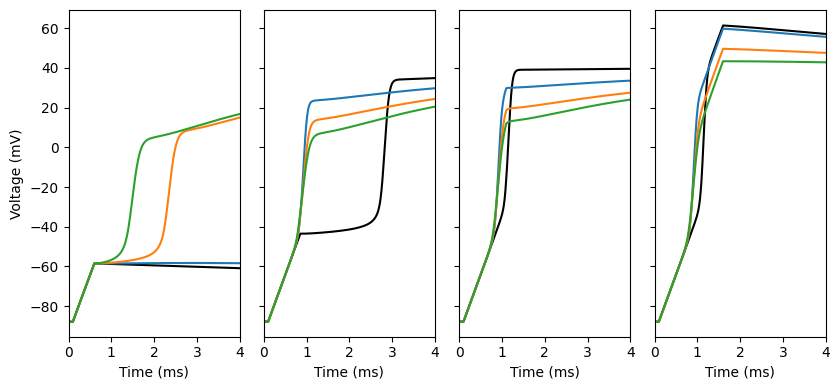

In [10]:
# Test different stim durations (take off potential) with zoom in to upstrokes

fig, axes = plt.subplots(1, 4, figsize=(8.5, 4), sharex=True, sharey=True)

for i_v, v in enumerate([0.5, 0.75, 1, 1.5]):
    m = myokit.Simulation(mmt_ap)
    stim_amp_var = 'stimulus.amplitude'  # For dutta-2017.mmt
    m.set_max_step_size(1e-1)  # ms
    m.set_tolerance(1e-8, 1e-10)
    m.set_constant(stim_amp_var, -80)
    p = myokit.pacing.blocktrain(period=500,
                                 #duration=1,
                                 duration=v,
                                 offset=0.1,
                                 level=0.75)
                                 #level=2)
                                 #level=0.75)
    m.set_protocol(p, label='pace')
    m.pre(10000)

    colors = ['black','C0', 'C1', 'C2']
    for i, p in enumerate(PARAMS):
        m.set_constant('ina.gNa', p[0])
        m.set_constant('ina.p1', p[1])
        m.set_constant('ina.p3', p[1])
        d0 = m.run(TIME[-1]+1, log=LOG+['engine.time'])
        m.reset()
        axes[i_v].plot(d0.time(), d0['membrane.V'], c=colors[i])

    axes[i_v].set_xlabel('Time (ms)')

axes[0].set_ylabel('Voltage (mV)')
axes[0].set_xlim([0, 4])
plt.tight_layout()
plt.show()

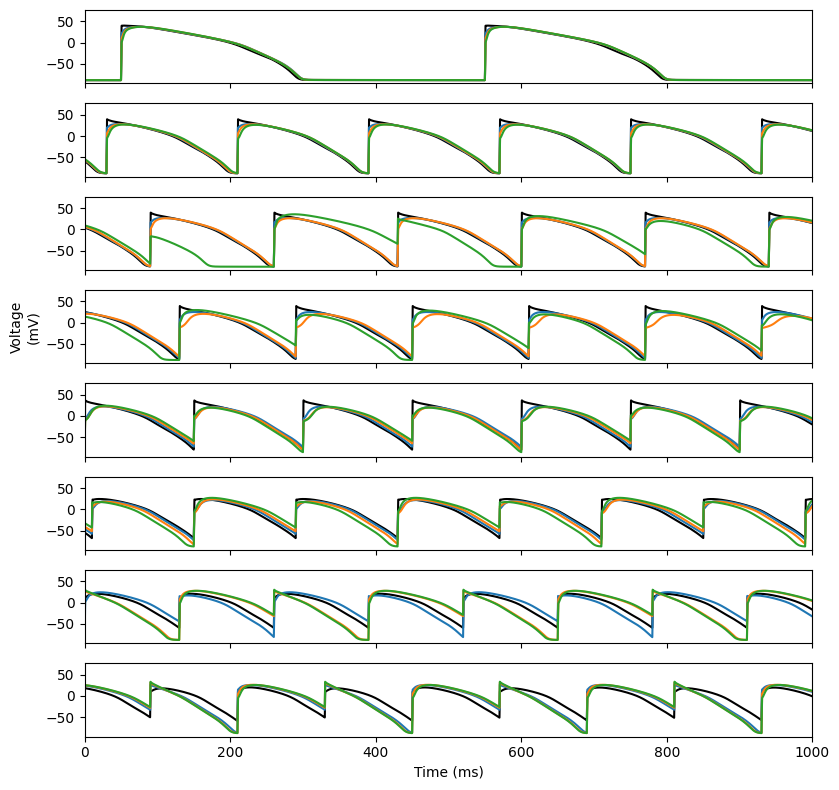

In [11]:
# Test different pacing frequencies

fig, axes = plt.subplots(8, 1, figsize=(8.5, 8), sharex=True, sharey=True)

TIME2= np.arange(0, 5000, DT)

for i_v, v in enumerate([500, 180, 170, 160, 150, 140, 130, 120]):
    m = myokit.Simulation(mmt_ap)
    stim_amp_var = 'stimulus.amplitude'  # For dutta-2017.mmt
    m.set_max_step_size(1e-1)  # ms
    m.set_tolerance(1e-8, 1e-10)
    m.set_constant(stim_amp_var, -80)
    p = myokit.pacing.blocktrain(period=v,
                                 #duration=1,
                                 duration=0.5,
                                 offset=50,
                                 level=1.5)
                                 #level=2)
                                 #level=0.75)
    m.set_protocol(p, label='pace')
    m.pre(10000)

    colors = ['black','C0', 'C1', 'C2']
    for i, p in enumerate(PARAMS):
        m.set_constant('ina.gNa', p[0])
        m.set_constant('ina.p1', p[1])
        m.set_constant('ina.p3', p[1])
        d0 = m.run(TIME2[-1]+1, log_times=TIME2, log=LOG)
        m.reset()
        axes[i_v].plot(TIME2 - 2000, d0['membrane.V'], c=colors[i])

axes[3].set_ylabel('Voltage\n(mV)')
axes[-1].set_xlabel('Time (ms)')
axes[0].set_xlim([0, 1000])
plt.tight_layout()
plt.show()

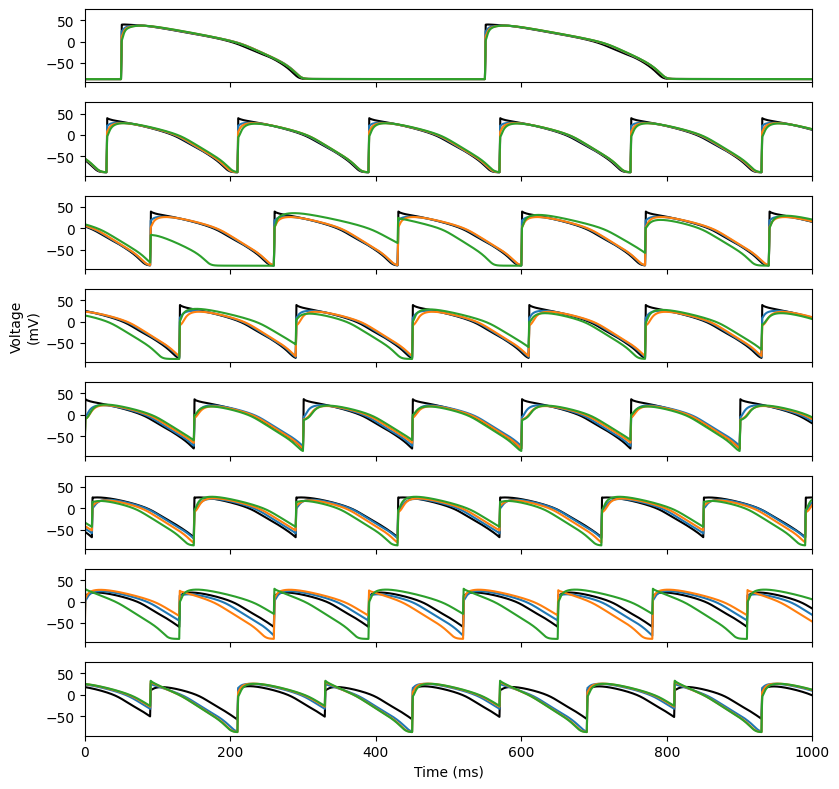

In [12]:
# Test different pacing frequencies

fig, axes = plt.subplots(8, 1, figsize=(8.5, 8), sharex=True, sharey=True)

TIME2= np.arange(0, 5000, DT)

for i_v, v in enumerate([500, 180, 170, 160, 150, 140, 130, 120]):
    m = myokit.Simulation(mmt_ap)
    stim_amp_var = 'stimulus.amplitude'  # For dutta-2017.mmt
    m.set_max_step_size(1e-1)  # ms
    m.set_tolerance(1e-8, 1e-10)
    m.set_constant(stim_amp_var, -80)
    p = myokit.pacing.blocktrain(period=v,
                                 #duration=1,
                                 duration=0.75,
                                 offset=50,
                                 level=1)
                                 #level=2)
                                 #level=0.75)
    m.set_protocol(p, label='pace')
    m.pre(10000)

    colors = ['black','C0', 'C1', 'C2']
    for i, p in enumerate(PARAMS):
        m.set_constant('ina.gNa', p[0])
        m.set_constant('ina.p1', p[1])
        m.set_constant('ina.p3', p[1])
        d0 = m.run(TIME2[-1]+1, log_times=TIME2, log=LOG)
        m.reset()
        axes[i_v].plot(TIME2 - 2000, d0['membrane.V'], c=colors[i])

axes[3].set_ylabel('Voltage\n(mV)')
axes[-1].set_xlabel('Time (ms)')
axes[0].set_xlim([0, 1000])
plt.tight_layout()
plt.show()

Conduction velocity: 53.675560959293485 [cm/s]


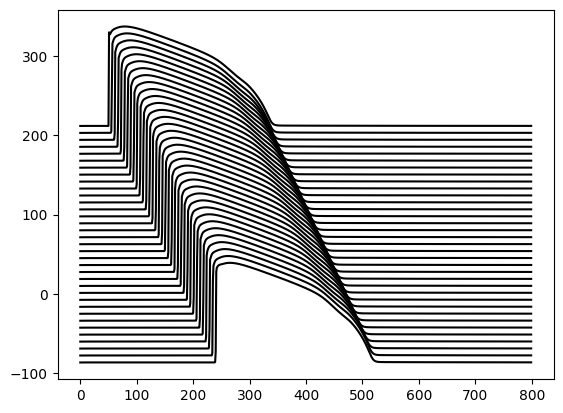

Conduction velocity: 56.76622620343293 [cm/s]


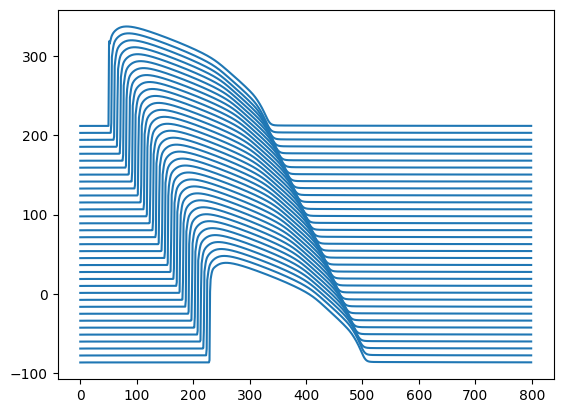

Conduction velocity: 45.76077522435771 [cm/s]


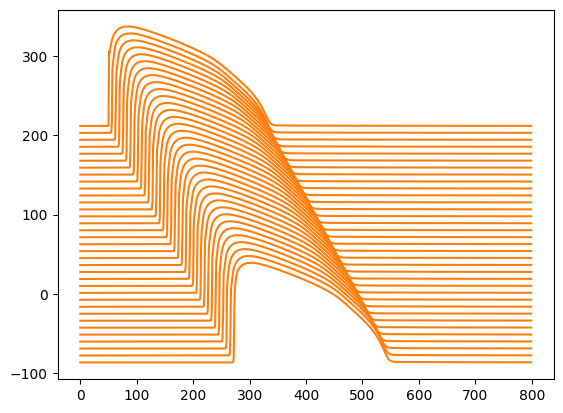

Conduction velocity: 36.58751546027188 [cm/s]


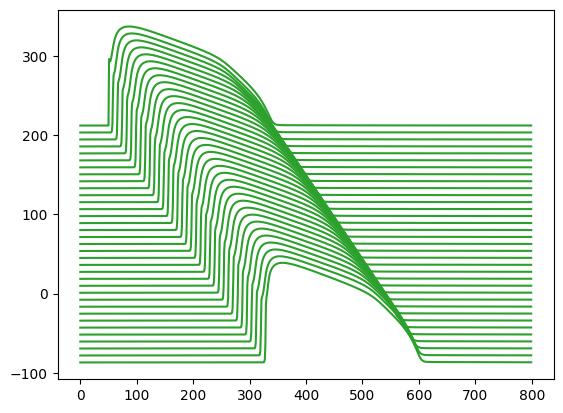

In [17]:
n = 1024#128
protocol = myokit.pacing.blocktrain(period=1000,
                                    #duration=1,
                                    duration=0.75,
                                    offset=50,
                                    level=1)

colors = ['black','C0', 'C1', 'C2']
for i, p in enumerate(PARAMS):
    mmt_ap.set_value('ina.gNa', p[0])
    mmt_ap.set_value('ina.p1', p[1])
    mmt_ap.set_value('ina.p3', p[1])
    s = myokit.Simulation1d(mmt_ap, protocol, ncells=n)
    #s.set_paced_cells(50)
    s.set_conductance(9)
    #s.set_conductance(15)
    s.set_step_size(0.01)
    try:
        # Run
        t = 800
        s.pre(5000)
        d = s.run(t, log_interval=1, log=['engine.time', 'membrane.V'])

        # Get 1d datablock representation
        b = d.block1d()

        # Calculate conduction velocity
        cv = b.cv('membrane.V')
        print('Conduction velocity: ' + str(cv) + ' [cm/s]')

        # Show color coded plot
        x,y,z = b.grid('membrane.V')
        plt.figure()
        #plt.pcolormesh(x,y,z)
        #plt.grid(False)
        #plt.xlim(0, t)
        #plt.ylim(0, n)
        #plt.colorbar()
        for k, j in enumerate(np.arange(0, n, 30)):
            plt.plot(x[j][:-1], z[j] + (n/30 - k)/(n/30)*100*2, c=colors[i])
        plt.show()

    except myokit.SimulationError as e:
        print(str(e))